# Canine Cutaneous Tumor Classification

## Import packages

In [1]:
import sys 
sys.path.insert(0, '..')
from fastai.utils.collect_env import show_install
from fastai.vision import *
from slide.slide_helper import SlideSegmentationItemList, SlideClassificationLabelList
from slide.process_slides import *
from fastai.callbacks.tracker import SaveModelCallback
from efficientnet_pytorch import EfficientNet

## Label function

In [2]:
def get_y_func(x):
    label_dict = {7:'Melanoma', 8:'Plasmacytoma', 9:'Mast Cell Tumor', 10:'PNST', 11:'SCC', 12:'Trichoblastoma', 13:'Histiocytoma'}
    return label_dict[[l for l in x.labels if l >= 7][0]]

## Confirm that you have a GPU up and running

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
show_install()



```text
=== Software === 
python        : 3.7.3
fastai        : 1.0.61
fastprogress  : 0.2.7
torch         : 1.6.0+cu101
nvidia driver : 442.83
torch cuda    : 10.1 / is available
torch cudnn   : 7604 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 4096MB | Quadro T1000
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.



## Define model parameters

In [17]:
patch_size = 1024
patches_per_slide = 10 # define number of pathes sampled per slide for each pseudo-epoch
batch_size = 8
level = 0  # resolution level of image pyramid (higher level corresponds to lower resoution)
lr = 1e-3
encoder = EfficientNet.from_pretrained("efficientnet-b5", num_classes=8)

Loaded pretrained weights for efficientnet-b5


## Define paths of slide folder and annotation JSON

In [18]:
target_folder = Path("../catch")
annotation_file = "../CATCH.json"

## Define dict to match annotation classes used for training
> Label classes that shall be exluded from training with -1

In [6]:
label_dict = {'Bg': -1, 'Bone': -1, 'Cartilage': -1, 'Dermis': 0, 'Epidermis': 0, 'Subcutis': 0,'Inflamm/Necrosis': 0, 'Melanoma': 1, 'Plasmacytoma': 2, 'Mast Cell Tumor': 3, 'PNST': 4, 'SCC': 5,'Trichoblastoma': 6, 'Histiocytoma': 7}

## Load slides using custom SlideContainer format and split into train, validation and test set

In [7]:
train_files, valid_files, _ = load_slides(["train","valid"], patch_size, label_dict, level, target_folder, annotation_file=annotation_file, dataset_type='classification')

100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [19:58<00:00,  3.42s/it]


## Adjust probabilities to sample tumor and healthy classes equally

In [8]:
for slide in train_files:
    slide.probabilities.update((k, ((1 / 8) / (len(slide.probabilities)-1) if k < 7 else 7 / 8)) for k in slide.probabilities.keys())
for slide in valid_files:
    slide.probabilities.update((k, ((1 / 8) / (len(slide.probabilities)-1) if k < 7 else 7 / 8)) for k in slide.probabilities.keys())

## Sample patches

In [9]:
train_data = create_patches(train_files, patches_per_slide)
valid_data = create_patches(valid_files, patches_per_slide)

## Use standard [transforms](https://fastai1.fast.ai/vision.transform.html) for augmentation provided by fastai

In [10]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=45,
                      max_lighting=0.15, 
                      max_zoom=2)

## Create fastai databunch

In [19]:
train = SlideSegmentationItemList(train_data)
valid = SlideSegmentationItemList(valid_data)
path = Path('.')
item_list = ItemLists(path, train, valid)
item_list = item_list.label_from_func(get_y_func,classes=['Non-Neoplastic', 'Melanoma', 'Plasmacytoma','Mast Cell Tumor', 'PNST', 'SCC', 'Trichoblastoma', 'Histiocytoma'],label_cls=SlideClassificationLabelList)
#data = item_list.transform(tfms, size=patch_size).databunch(bs=batch_size).normalize()
data = item_list.transform(tfms, size=patch_size).databunch(bs=batch_size, num_workers=0).normalize(([0.7587, 0.5718, 0.6572],[0.0866, 0.1118, 0.0990])) # For Windows set num_workers = 0

## Let's have a look at the data

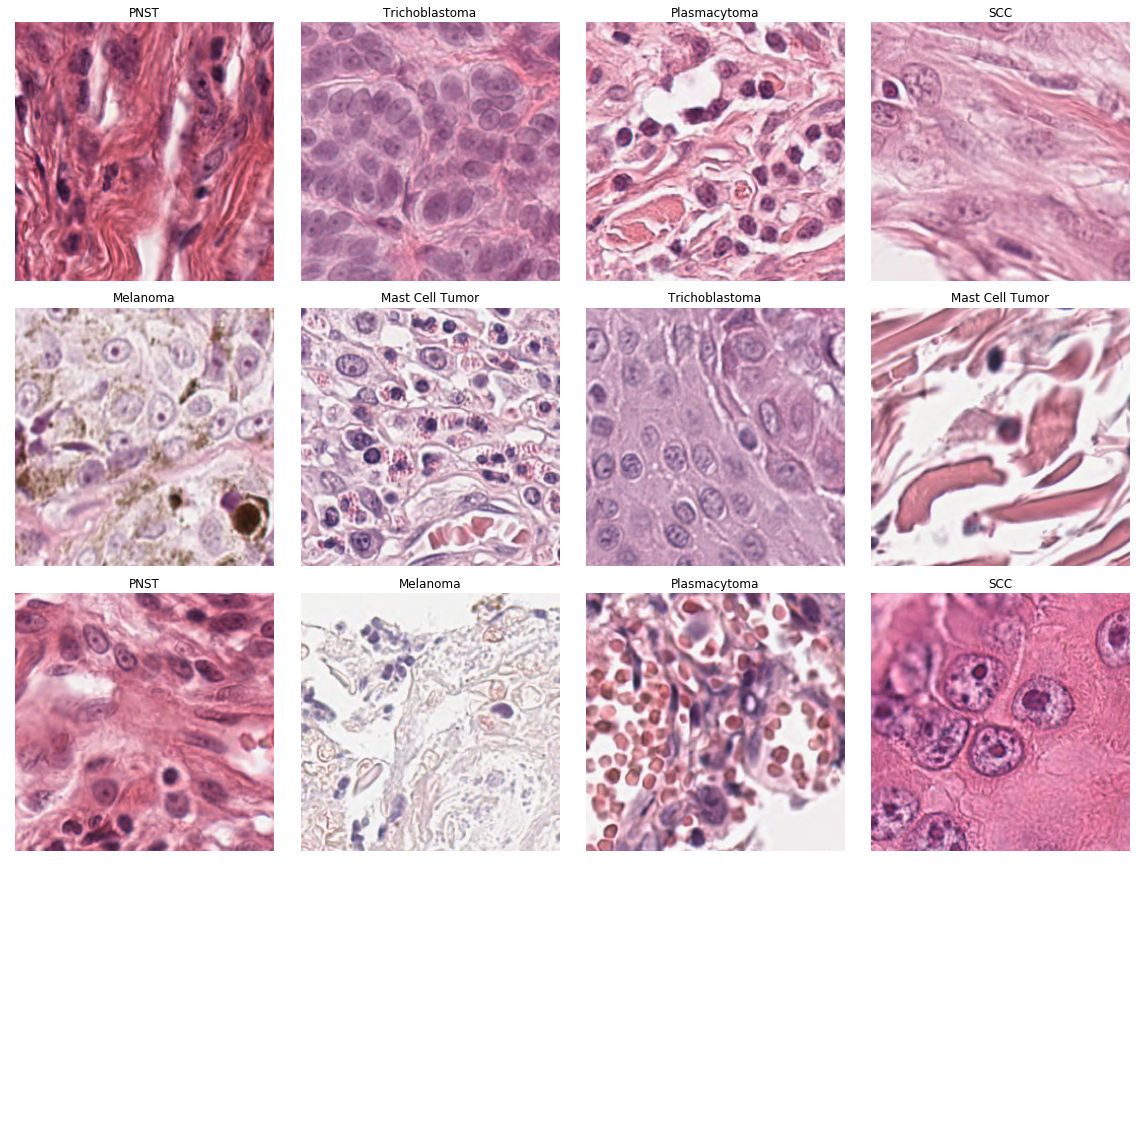

In [20]:
data.show_batch(ds_type=DatasetType.Valid)

## Initialize learner

In [13]:
learn = Learner(data, encoder, metrics=accuracy,callback_fns=[ShowGraph])

## Start training

epoch,train_loss,valid_loss,accuracy,time
0,2.026172,1.918706,0.057143,01:33
1,2.059675,5.663542,0.057143,01:10
2,2.024727,4.066365,0.142857,01:13
3,1.949509,2.028397,0.228571,01:07
4,1.822177,1.581105,0.342857,01:16


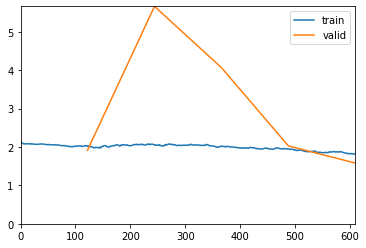

Better model found at epoch 0 with accuracy value: 0.05714285746216774.
Better model found at epoch 2 with accuracy value: 0.1428571492433548.
Better model found at epoch 3 with accuracy value: 0.22857142984867096.
Better model found at epoch 4 with accuracy value: 0.34285715222358704.


In [14]:
learn.fit_one_cycle(5, lr, callbacks=SaveModelCallback(learn, every='improvement', monitor='accuracy',name='classification_learner'))

## Let's have a look at some results

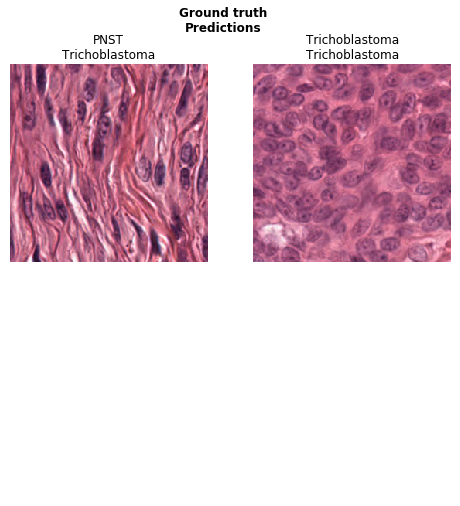

In [15]:
learn.show_results(ds_type=DatasetType.Valid)

## Export learner

In [16]:
learn.export('classification_learner.pkl')